<a id="inicio"></a>
<br><br><br>
<h2><font color="#B51700" size=5>Dataset Spaceship Titanic</font></h2>



<h1><font size=5>Analisis exploratorio, preprocesamiento de los datos y selección de modelos</font></h1>


---

# 1. Introducción

En este notebook se trabajará con el problema del conjunto de datos `Spaceship Titanic`, el cual ha sido extraido de la competición de `kaggle` [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic). El objetivo es predecir si unos pasajeros que estaban viajando en una nave espacial llamada Titanic han sido transportados a otra dimensión. Este conjunto de datos es muy útil para aprender a trabajar con problemas de machine learning, ya que cuenta con muchas características típicas de estos problemas que iremos viendo a lo largo del notebook (por ejemplo cuenta con outliers y valores nulos).

El objetivo de este notebook es ser bastante completo y que pueda ser usado como guía para trabajar con este tipo de problemas. Primero se realizará un análisis exploratorio (dividido en un análisis univariado y multivariado). De este estudio se extraerán varias conclusiones que nos permitirán realizar un buen preprocesamiento de los datos. Para el preprocesamiento de los datos se utilizará el concepto de `pipeline` para evitar realizar una fuga de datos (evitar introducir información del conjunto de test en el conjunto de entrenamiento). Además, el uso de una `pipeline` nos permite crear un objeto que realizará todas las transformaciones sobre los datos de una vez, lo que reduce la probabilidad de que ocurra un error en este paso. Para crear el `pipeline` se utilizarán componentes de la librería `sklearn` y también crearemos alguno nosotros.

Finalmente, se entrenarán varios modelos utilizando una validación cruzada para seleccionar los parámetros que mejor funcionen para cada modelo, y después, se creará un `ensemble` con los modelos que mejor resultados han obtenido para intentar mejorar sus resultados. El objetivo no es obtener un score demasiado alto, sino aprender a trabajar con estos problemas de machine learning. Aún así se han obtenido muy buenos resultados (un 80% de accuracy para los datos de test).

Empezaremos importando las librerías necesarias.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix

# 2. Carga de datos

Antes de cargar los datos y empezar con el análisis exploratorio se va a establecer una semilla para que los resultados obtenidos a lo largo de la libreta puedan ser reproducibles.

In [2]:
seed = 42

Se van a cargar los datos de entrenamiento, que serán los que se utilicen para realizar el análisis exploratorio y para el entrenamiento de los modelos.

In [3]:
filepath = 'train.csv'
index = 'PassengerId'
data = pd.read_csv(filepath, index_col=index)

Se visualizan algunos registros aleatorios para comprobar que se han cargado los datos correctamente. Mostraremos algunos al azar para evitar obtener una muestra sesgada que no represente al conjunto de datos.

In [4]:
data.sample(5, random_state=seed)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0337_02,Mars,False,F/63/S,TRAPPIST-1e,19.0,False,417.0,349.0,634.0,3.0,1057.0,Weros Perle,True
2891_01,Earth,False,G/460/S,TRAPPIST-1e,18.0,False,4.0,904.0,0.0,0.0,1.0,Gleney Ortinericey,False
8998_01,Earth,True,G/1449/S,TRAPPIST-1e,41.0,False,0.0,0.0,0.0,0.0,0.0,Gerry Englence,False
1771_01,Earth,False,G/291/P,TRAPPIST-1e,35.0,False,0.0,338.0,436.0,NaN,0.0,Antone Cardner,True
9034_02,Europa,True,D/288/P,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,Errairk Crakete,True


# 3. Análisis exploratorio

Para comenzar con el análisis exploratorio, primero vamos a visualizar la información general del dataset.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB


Podemos ver que contamos con 8693 registros para el entrenamiento. También se obtiene la siguiente información sobre las variables del dataset:

* ***HomePlanet***: tiene valores nulos. Tipo object.
* ***CryoSleep***: tiene valores nulos. Tipo object.
* ***Cabin***: tiene valores nulos. Tipo object.
* ***Destination***: tiene valores nulos. Tipo object.
* ***Age***: tiene valores nulos. Tipo float64.
* ***VIP***: tiene valores nulos. Tipo object.
* ***RoomService***: tiene valores nulos. Tipo float64.
* ***FoodCourt***: tiene valores nulos. Tipo float64.
* ***ShoppingMall***: tiene valores nulos. Tipo float64.
* ***Spa***: tiene valores nulos. Tipo float64.
* ***VRDeck***: tiene valores nulos. Tipo float64.
* ***Name***: tiene valores nulos. Tipo object.
* ***Transported***: es la variable clase. Tipo bool.

Podemos ver el porcentaje de valores nulos que hay en el conjunto de datos.

In [6]:
missing_values=data.isnull().sum()
missing_values[missing_values>0]/len(data)*100

HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
dtype: float64

Vemos que todas las variables contienen algún valor nulo, aunque ninguna tiene más del 3% de sus datos como valores nulos.

## 3.1. Análisis univariado

Vamos a empezar obteniendo un resumen de la información de los campos numéricos.

In [7]:
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


Con esta instrucción se obtiene información muy útil de todas las variables numéricas, como su valor máximo o su media.

También nos permite detectar la presencia de outliers mediante el uso de los cuartiles y el valor máximo. Por ejemplo, para la variable `RoomService` observamos que el 75% de los datos tiene un valor inferior a 47, y sin embargo existe un valor máximo de 29813, siendo este claramente un outlier. Se ha detectado la presencia de algún outlier en todas las variables numéricas.

Vamos a visualizar la cantidad de outliers que presentan estas variables.

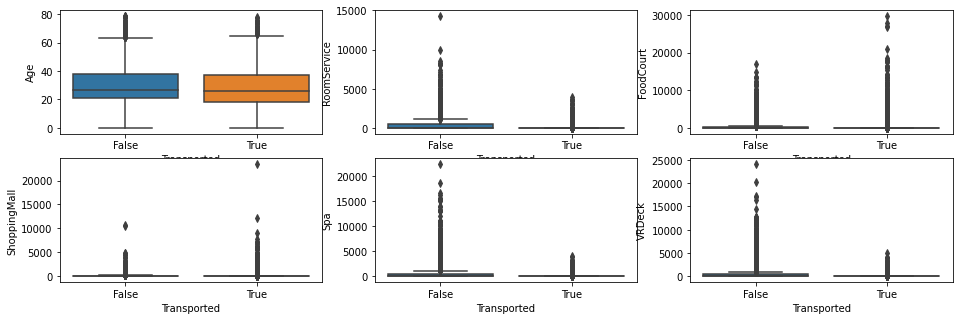

In [8]:
plt.figure(figsize=(16,5))

features_outlier = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for i,col in enumerate(features_outlier):    
    plt.subplot(2,3,i + 1)
    sns.boxplot(y=col, x='Transported', data=data)

plt.show()

Vamos a calcular cuantos outliers hay para cada una de estas variables:

In [9]:
def outlier_detect(feature, data):
    outlier_index = {}

    for col in feature:
        Q1 = np.nanpercentile(data[col], 25)
        Q3 = np.nanpercentile(data[col], 75)
        IQR = Q3 - Q1
        min_quartile = Q1 - 1.5*IQR
        max_quartile = Q3 + 1.5*IQR
        outlier_points = data[(data[col] < min_quartile) | (data[col] > max_quartile)]
        outlier_index[col] = outlier_points[col]
    return outlier_index

In [10]:
outliers = outlier_detect(features_outlier, data)

for col in outliers:
    print(col, ': ',len(outliers[col]) , ' outliers')

Age :  77  outliers
RoomService :  1861  outliers
FoodCourt :  1823  outliers
ShoppingMall :  1829  outliers
Spa :  1788  outliers
VRDeck :  1809  outliers


Todas estas variables cuentan con bastantes outliers.

Vamos a estudiar cada variable de forma independiente y como se relaciona cada variable con la variable clase, pero sin tener en cuenta la relación entre varias variables (análisis univariado).

Para ello primero se va a definir una función llamada `categorical_plot`, que generará dos gráficos para las variables categóricas.

* El primer gráfico muestra la cantidad de valores que tiene cada categoría de la variable.
* El segundo gráfico muestra la relación entre la variable clase y la variable categórica indicada.

In [11]:
def categorical_plot(data, x, y):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.countplot(x=x, data=data, ax=axes[0])
    axes[0].set_title('Count Plot')

    sns.barplot(x=x, y=y, data=data, ax=axes[1])
    axes[1].set_title('Bar Plot')

    plt.tight_layout()
    plt.show()

### Transported

Primero vamos a ver la variable clase, que como observamos es una variable categórica que puede tomar los valores true (pasajero se transportó a otra dimensión) y false (no se transportó). Tenemos un dataset balanceado, en el que hay una cantidad similar de casos true que false.

<AxesSubplot:xlabel='Transported', ylabel='count'>

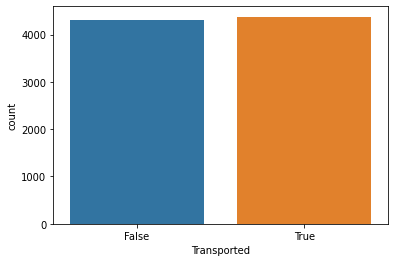

In [12]:
sns.countplot(x='Transported',data=data)

In [13]:
data['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

### HomePlanet

Vamos a analizar la variable `HomePlanet` que almacena el planeta del que partió el pasajero. Es una variable categórica que puede tomar los valores `Europa`, `Earth` y `Mars`.

Vemos que hay muchos mas pasajeros del planeta `Earth` que de los otros dos.

Parece que hay alguna relación directa entre la variable clase `Transported` y la variable `HomePlanet`. Observamos que se transportaron más pasajeros de Europa que de los otros planetas.

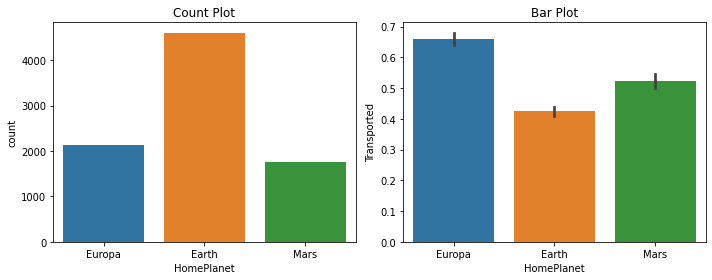

In [14]:
categorical_plot(data, 'HomePlanet', 'Transported')

### CryoSleep

La variable `CryoSleep` indica si el pasajero ha permanecido en animación suspendida durante el viaje. Estos pasajeros en criosueño están confinados en sus camarotes (puede que haya alguna relación entre esta variable y los camarotes).

Observamos que hay muchos más pasajeros que no han permanecido en animación suspendida.

Hay una relación directa con la variable clase. La mayoría de los pasajeros que permanecieron en animación suspendida han sido transportados a otra dimensión.

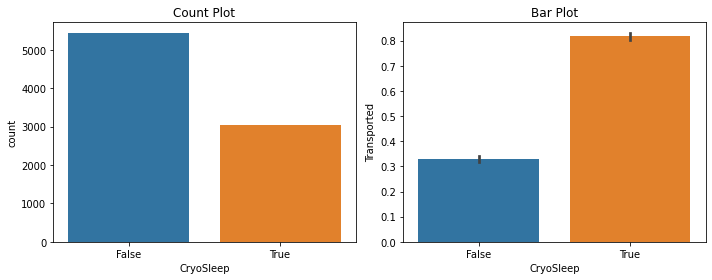

In [15]:
categorical_plot(data, 'CryoSleep', 'Transported')

### Cabin

Representa el número de la cabina donde estuvo el pasajero. Tiene la forma deck/num/side, `side` puede ser `P` (puerto) o `S` (estribor). A priori esta variable no aporta información útil, aunque se pueden obtener varias características a partir de ella que aportan información útil para este problema.

In [16]:
data['Cabin'].value_counts()

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

### Destination

Indica el planeta al que se dirigía el pasajero. Es una variable categórica con tres posibles valores. 

Observamos que la mayoría de los pasajeros se dirigían a `TRAPPIST-1e`. 

Esta variable no parece tener mucha relación directa con la variable clase, ya que se transportaron el 50% de los pasajeros, independientemente del destino al que se dirigían.

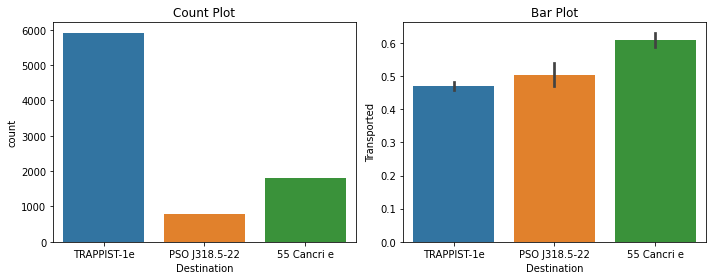

In [17]:
categorical_plot(data, 'Destination', 'Transported')

### Age

Indica la edad del pasajero y es una variable numérica. La mayoría de los pasajeros tenían entre 18 y 50 años. Sigue una distribución normal.

<AxesSubplot:xlabel='Age', ylabel='Density'>

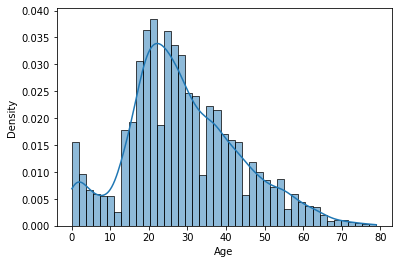

In [18]:
sns.histplot(data['Age'], kde=True, stat='density')

### VIP

Indica si el pasajero tenía un billete VIP.

La mayoría de los pasajeros no tenían los servicios VIP (al haber tampocos casos de pasajeros con servicios VIP convendría eliminar la variable, ya que no aporta mucha información).

Parece que hay una relación directa entre esta varialbe y la variable clase, debido a que los pasajeros que no tenían servicios VIP se han transportado más.

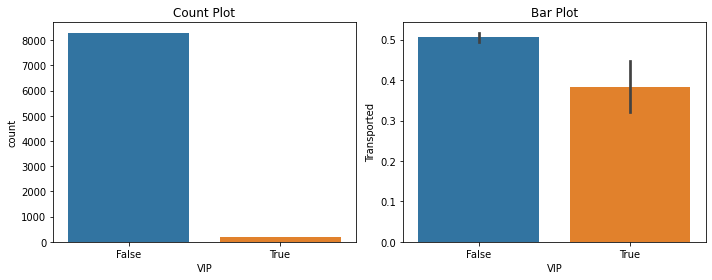

In [19]:
categorical_plot(data, 'VIP', 'Transported')

### RoomService

Es la cantidad de dinero que los pasajeros se han gastado en servicios de habitaciones.

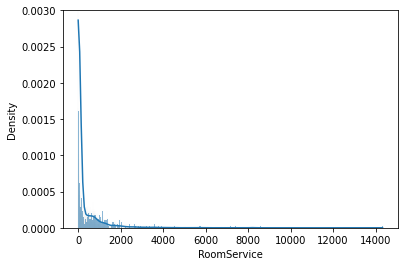

In [20]:
sns.histplot(data['RoomService'], kde=True, stat='density')
plt.ylim(0, 0.003)
plt.show()

### FoodCourt

Cantidad de dinero que los pasajeros se han gastado en comidas.

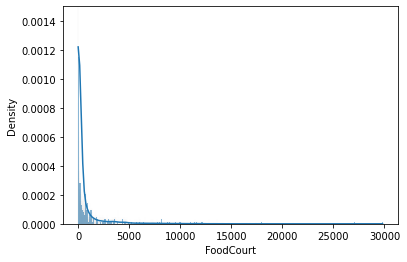

In [21]:
sns.histplot(data['FoodCourt'], kde=True, stat='density')
plt.ylim(0, 0.0015)
plt.show()

### ShoppingMall

Cantidad de dinero que los pasajeros se han gastado en ir de compras.

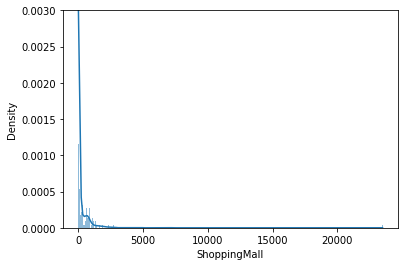

In [22]:
sns.histplot(data['ShoppingMall'], kde=True, stat='density')
plt.ylim(0, 0.003)
plt.show()

### Spa

Cantidad de dinero que los pasajeros se han gastado en el spa.

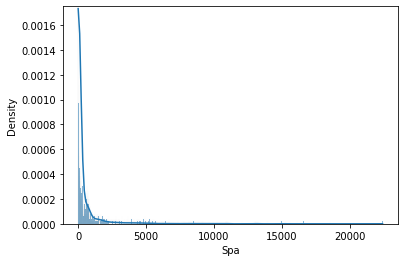

In [23]:
sns.histplot(data['Spa'], kde=True, stat='density')
plt.ylim(0, 0.00175)
plt.show()

### VRDeck

Cantidad de dinero que los pasajeros se han gastado en la cubierta de RV.

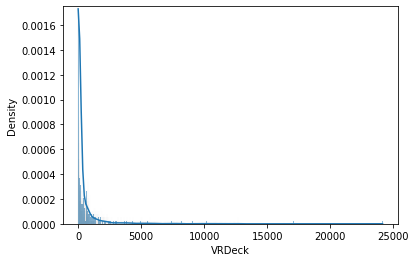

In [24]:
sns.histplot(data['VRDeck'], kde=True, stat='density')
plt.ylim(0, 0.00175)
plt.show()

### Name

Contiene el nombre y apellido de los pasajeros. Esta variable no aporta información útil, así que se descartará para el entrenamiento.

In [25]:
data['Name'].head()

PassengerId
0001_01      Maham Ofracculy
0002_01         Juanna Vines
0003_01        Altark Susent
0003_02         Solam Susent
0004_01    Willy Santantines
Name: Name, dtype: object

### Passenger Id

Un Id único para cada pasajero. Cada Id tiene la forma gggg_pp, donde gggg indica el grupo con el que viaja el pasajero y pp es su número dentro del grupo. Los miembros de un grupo suelen ser familiares, pero no siempre.

Esta variable sin procesar no aporta información, pero se pueden extraer variables útiles a partir de ella.

In [26]:
data.index

Index(['0001_01', '0002_01', '0003_01', '0003_02', '0004_01', '0005_01',
       '0006_01', '0006_02', '0007_01', '0008_01',
       ...
       '9272_02', '9274_01', '9275_01', '9275_02', '9275_03', '9276_01',
       '9278_01', '9279_01', '9280_01', '9280_02'],
      dtype='object', name='PassengerId', length=8693)

## 3.2. Construcción de nuevas características

### Suma de gastos

A partir de todas las variables numéricas que representan gastos de los pasajeros, se puede generar una nueva variable `Expenses` que represente los gastos totales de los pasajeros (la suma de todos los gastos individuales).

In [27]:
data['Expenses'] = data['RoomService'] + data['FoodCourt'] + data['ShoppingMall'] + data['Spa'] + data['VRDeck']
data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Expenses
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0


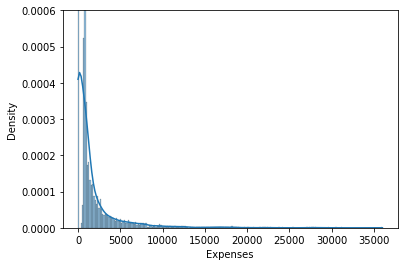

In [28]:
sns.histplot(data['Expenses'], kde=True, stat='density')
plt.ylim(0, 0.0006)
plt.show()

### Cabin

De la cabina se van a extraer dos categorías:

* `Deck`: indica la cubierta de la cabina.

* `Side`: indica si la cabina está en puerto (`P`) o estribor (`S`). 

Parece que ambas categorías tienen relación directa con la variable clase.

In [29]:
data[['Deck', 'Side']] = data['Cabin'].str.split('/', expand=True)[[0, 2]]
data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Expenses,Deck,Side
PassengerId,,,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,B,P
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,F,S
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,A,S
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,A,S
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,F,S


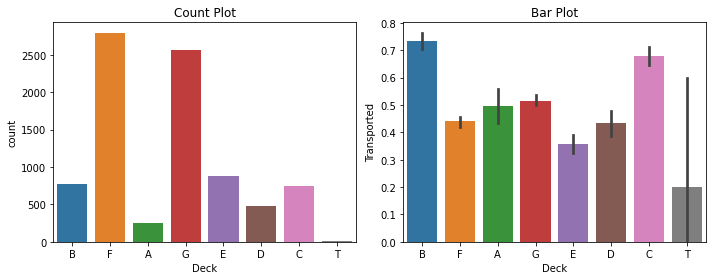

In [30]:
categorical_plot(data, 'Deck', 'Transported')

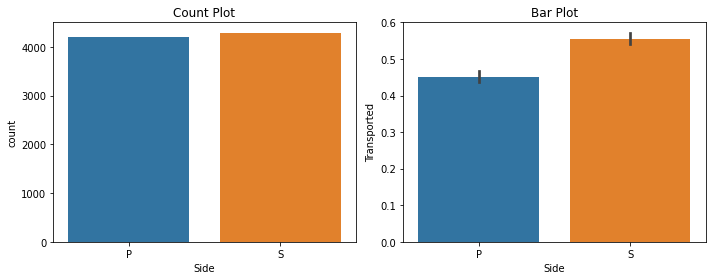

In [31]:
categorical_plot(data, 'Side', 'Transported')

### PassengerId

A partir del `PassengerId` se pueden extraer dos categorías:

* `GroupId`: id del grupo en el que iba el pasajero. Hay demasiadas categorías, y parece que no aporta nada al problema (se eliminará).

* `GroupSize`: tamaño del grupo en el que iba en el pasajero. Parece que no hay mucha relación entre esta variable y la variable clase.

In [32]:
passengerId = pd.DataFrame(data.index)
passengerId[['GroupId', 'GroupSize']] = passengerId['PassengerId'].str.split('_', expand=True)
passengerId.set_index('PassengerId', inplace=True)
passengerId.head()

,GroupId,GroupSize
PassengerId,,
0001_01,0001,01
0002_01,0002,01
0003_01,0003,01
0003_02,0003,02
0004_01,0004,01


In [33]:
data['GroupSize'] = passengerId.groupby("GroupId")["GroupId"].transform("count")
data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Expenses,Deck,Side,GroupSize
PassengerId,,,,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,B,P,1
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,F,S,1
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,A,S,2
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,A,S,2
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,F,S,1


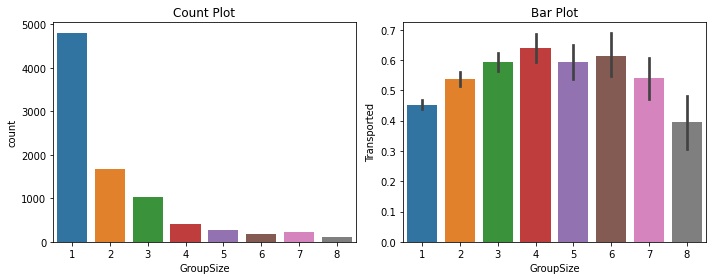

In [34]:
categorical_plot(data, 'GroupSize', 'Transported')

## 3.3. Análisis multivariado

Para el análisis multivariado se va a generar una matriz de correlación entre las variables numéricas.

De la matriz de correlación podemos observar la relación que hay entre las distintas variables (y si esta relación es positiva o negativa). Por ejemplo, podemos ver que la variable `Expenses` está relacionada con todas las variables de gastos (esto es lógico ya que se ha construido a partir de ellas), además esta un poco relacionada con la variable `Age` y `Transported`. También podemos observar como la variable `GroupSize` no está relacionada con ninguna variable, por lo que la podemos obviar en el entrenamiento.

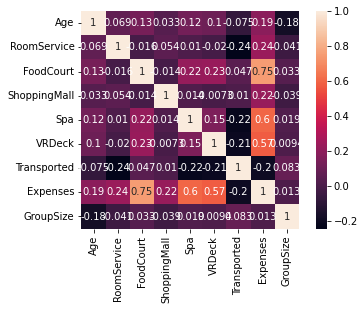

In [35]:
sns.heatmap(data.corr(), annot=True, square=True)
plt.show()

## 3.4. Conclusiones análisis exploratorio

Estas son las conclusiones que se han ido sacando a lo largo del análisis exploratorio:

* ***Transported***: variable clase balanceada con dos categorías (true o false).
* ***HomePlanet***: tiene relación directa con la variable clase.
* ***CryoSleep***: tiene relación directa con la variable clase.
* ***Destination***: tiene relación directa con la variable clase.
* ***VIP***: no aporta información útil porque la mayoría de los pasajeros no tenían contratados los servicios VIP.
* ***Age***: tiene relación con algunas variables.
* ***RoomService***: tiene relación con otras variables.
* ***FoodCourt***: tiene relación con otras variables.
* ***ShoppingMall***: tiene relación con otras variables.
* ***Spa***: tiene relación con otras variables.
* ***VRDeck***: tiene relación con otras variables.
* ***Expenses***: tiene relación con otras variables.
* ***Name***: no aporta información útil.
* ***Cabin***: no aporta información útil. Se han extraído varias características a partir de ella:
    * ***Deck***: tiene relación directa con la variable clase.
    * ***Side***: tiene relación directa con la variable clase.
* ***PassengerId***: no aporta información útil. Se ha extraído una característica a partir de ella:
    * ***GroupSize***: solo tiene un poco de relación con la variable Age. No se va a utilizar.
* Todas las variables cuentan con valores nulos (un 2%).
* Las variables numéricas cuentan con bastantes outliers.
* El problema cuenta con varias características categóricas que serán necesario codificar.

# 4. Preprocesamiento de datos

Después de terminar el análisis exploratorio de datos, vamos a intentar preparar los datos a partir de las conclusiones que hemos obtenido para obtener un mejor rendimiento al entrenar los modelos.

Para realizar todas las transformaciones necesarias sobre los datos se va a utilizar el concepto de `pipeline`. En un pipeline se definen todas las transformaciones que queremos aplicar sobre los datos y el pipeline se encarga de realizarlas todas, tanto para los datos de entrenamiento como para los de prueba. Además, con el uso de un pipeline nos aseguramos de no cometer `fuga de datos`, es decir, no se introducirá información del conjunto de prueba en los datos utilizados para entrenar a los modelos.

## Construcción de nuevas características

Crearemos unos `custom transformers` para generar las nuevas características `Expenses`, `Deck` y `Side`.
* Para la variable `Expenses` se sumarán todas las variables de gastos del viaje.
* Las variables `Deck` y `Side` se extraerán de la variable `Cabin`. Recordemos que esta variable tenía el siguiente formato `D/_/S`, donde nos interesa extraer el primer y último cáracter.

In [36]:
class TotalExpensesTransformer(BaseEstimator, TransformerMixin): 
 
    def fit(self, X, y = None):
        return self
    
    def transform( self, X, y = None ):
        X['Expenses'] = X['RoomService'] + X['FoodCourt'] + X['ShoppingMall'] + X['Spa'] + X['VRDeck']
        return X

#expense_columns = TotalExpensesTransformer()

In [37]:
class CabinTransformer(BaseEstimator, TransformerMixin): 
 
    def fit(self, X, y = None):
        return self
    
    def transform( self, X, y = None ):
        X[['Deck', 'Side']] = X['Cabin'].str.split('/', expand=True)[[0, 2]]
        return X
    
#cabin_transformer = CabinTransformer()

## Eliminar columnas

Crearemos otro `custom transform` que se encargará de eliminar las columnas indicadas, para eliminar las columnas que hemos detectado que no aportan información útil.

In [38]:
class ColumnsDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)
    
#column_dropper = ColumnsDropper(['VIP', 'Name', 'Cabin'])

## Outliers

Para el tratamiento de outliers crearemos un `custom transformer` que les asignará a todos los outliers un valor máximo como límite.

In [39]:
class LimitOutlier(BaseEstimator, TransformerMixin): 
    
    def fit(self, X, y = None):
        self.limits = []
        for col in range(X.shape[1]):
            Q1 = np.nanpercentile(X[col], 25)
            Q3 = np.nanpercentile(X[col], 75)
            IQR = Q3 - Q1
            min_quartile = Q1 - 1.5*IQR
            max_quartile = Q3 + 1.5*IQR
            
            self.limits.append(max_quartile)
        
        return self
    
    def transform( self, X, y = None ):
        check_is_fitted(self, ['limits'])
        X2 = X.copy()
        for col in range(len(self.limits)):
            X2[col] = np.minimum(X[col], self.limits[col])
        return X2
    
#limit_outlier = LimitOutlier()

## Valores nulos

Para el tratamiento de valores nulos se realizará una imputación: 
* Para las variables categóricas se asignará el valor más frecuente.
* Para las variables numéricas se aplicará un knn. Ya que como vimos en el análisis exploratorio las características numéricas se relacionaban con el resto de características.

In [40]:
# categorical
most_frequency_imputer = SimpleImputer(strategy='most_frequent')

# numerical
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

## Encoding

Para las variables categóricas se codificarán mediante un `one hot encoding`.

In [41]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

## Construcción del pipeline

Ahora que se han definido todos los pasos de preprocesamiento se va a construir el `pipeline`. El `pipeline` realizará las siguientes operaciones en este orden:

![Pipeline](pipeline.png "Pipeline")

In [42]:
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenses']
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'Deck', 'Side']
drop_col = ['VIP', 'Name', 'Cabin']

In [43]:
numerical_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=5, weights='uniform')),
                                        ('outlier', LimitOutlier())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                  ('encoder', OneHotEncoder(handle_unknown='ignore'))])

column_transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='passthrough')


preprocessor = Pipeline(steps=[('totalexpenses', TotalExpensesTransformer()),
                               ('cabin', CabinTransformer()),
                               ('drop', ColumnsDropper(drop_col)),
                               ('columntransform', column_transformer)])

# 5. Entrenamiento de los modelos

Ahora que hemos definido un `pipeline` que contiene todo el preprocesamiento que queremos realizar sobre nuestros datos vamos a entrenar varios modelos a partir de estos datos preprocesados.

Un aspecto fundamental para obtener buenos resultados con algoritmos de aprendizaje es elegir los parámetros adecuados. En este caso se ha utilizado al objeto `GridSearchCV` que realiza una `validación cruzada` para elegir los parámetros que obtienen mejores resultados a partir de una lista de parámetros dada.

Después de obtener los mejores parámetros para cada modelo se realizará un emsemble con los mejores modelos obtenidos.

Para empezar cargaremos los datos que disponemos para validar y entrenar los modelos:

In [44]:
data = pd.read_csv(filepath, index_col=index)
X = data.drop(columns=['Transported'])
y = data['Transported']

Ahora dividiremos este conjunto de datos en dos:
- Conjunto de datos de entrenamiento: datos que se usarán para seleccionar la mejor configuración de parámetros para los modelos y entrenarlos con esa configuración.
- Conjunto de datos de validación: datos que se usarán después de entrenar los modelos con la mejor configuración de parámetros para evaluar su rendimiento.

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.18, random_state=seed)

Definimos una función que recibe un modelo, la configuración de parámetros que queremos validar y los datos para entrenar ese modelo. Esta función realizará una validación cruzada con 5 fold para elegir la mejor configuración de parámetros y posteriormente utilizará el conjunto de datos de entrenamiento completo para entrenar al modelo con la mejor configuración de parámetros.

In [46]:
def fitCV(model, parameters, X, y, preprocessor=preprocessor):

    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)])
    
    parameters['preprocessor__columntransform__num__imputer__n_neighbors'] = [5, 10]
    parameters['preprocessor__columntransform__num__imputer__weights'] = ['uniform', 'distance']
    
    GS = GridSearchCV(my_pipeline, param_grid=parameters, cv=5, scoring='accuracy', refit=True, verbose=0)
    GS.fit(X, y)
    
    print("Mejor score para la mejor configuracion de parametros: ", GS.best_score_)
    print("Mejor configuración de parámetros: ", GS.best_params_)
    
    return GS.best_estimator_

Ahora vamos a entrenar los siguientes algoritmos utilizando esta función:
- Support Vector Machine
- Regresión logística
- Árboles de decisión
- Ada Boost
- Bagging
- Random Forest
- Gradient Boosting
- Histogram Gradient Boosting

## SVM

In [47]:
model = SVC(random_state=seed)

parameters = {}
parameters['model__C'] = [0.75, 0.85, 0.95, 1]

svm = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.7895651189685294
Mejor configuración de parámetros:  {'model__C': 0.95, 'preprocessor__columntransform__num__imputer__n_neighbors': 10, 'preprocessor__columntransform__num__imputer__weights': 'uniform'}


## Regresión logística

In [48]:
model = LogisticRegression(solver='liblinear', random_state=seed)

parameters = {}
parameters['model__penalty'] = ['l1', 'l2']
parameters['model__C'] = [0.75, 0.85, 0.95, 1]
parameters['model__class_weight'] = [None, 'balanced']

logistic_regression = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.793351541546714
Mejor configuración de parámetros:  {'model__C': 0.85, 'model__class_weight': None, 'model__penalty': 'l2', 'preprocessor__columntransform__num__imputer__n_neighbors': 5, 'preprocessor__columntransform__num__imputer__weights': 'uniform'}


## Árbol de decisión

In [49]:
model = DecisionTreeClassifier(random_state=seed)

parameters = {}
parameters['model__criterion'] = ['gini', 'entropy']
parameters['model__ccp_alpha'] = [0.0, 0.1, 0.2]
parameters['model__max_depth'] = [5, 6, 10, 20]

decision_tree = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.7894244728230112
Mejor configuración de parámetros:  {'model__ccp_alpha': 0.0, 'model__criterion': 'gini', 'model__max_depth': 6, 'preprocessor__columntransform__num__imputer__n_neighbors': 10, 'preprocessor__columntransform__num__imputer__weights': 'uniform'}


## Ada boost

In [50]:
model = AdaBoostClassifier(random_state=seed)

base_estimator = DecisionTreeClassifier(random_state=seed)
parameters = {}
parameters['model__estimator'] = [base_estimator]
parameters['model__n_estimators'] = [50, 100, 200]
parameters['model__learning_rate'] = [0.95, 1.0]
parameters['model__estimator__max_depth'] = [1, 2]
parameters['model__estimator__criterion'] = ['gini', 'entropy']


ada = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.7905466893039049
Mejor configuración de parámetros:  {'model__estimator': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=42), 'model__estimator__criterion': 'entropy', 'model__estimator__max_depth': 1, 'model__learning_rate': 1.0, 'model__n_estimators': 100, 'preprocessor__columntransform__num__imputer__n_neighbors': 10, 'preprocessor__columntransform__num__imputer__weights': 'uniform'}


## Bagging

In [51]:
model = BaggingClassifier(random_state=seed)

base_estimator = DecisionTreeClassifier(random_state=seed)
parameters = {}
parameters['model__estimator'] = [base_estimator]
parameters['model__n_estimators'] = [50, 100, 200]

parameters['model__estimator__max_depth'] = [1, 4, 10]
parameters['model__estimator__criterion'] = ['gini', 'entropy']

bagging = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.7920898599936026
Mejor configuración de parámetros:  {'model__estimator': DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42), 'model__estimator__criterion': 'entropy', 'model__estimator__max_depth': 10, 'model__n_estimators': 200, 'preprocessor__columntransform__num__imputer__n_neighbors': 10, 'preprocessor__columntransform__num__imputer__weights': 'uniform'}


## Random forest

In [52]:
model = RandomForestClassifier(random_state=seed)

parameters = {}
parameters['model__n_estimators'] = [50, 100, 200]
parameters['model__max_features'] = ['sqrt', 'log2']
parameters['model__min_samples_split'] = [5, 10]
parameters['model__criterion'] = ['gini', 'entropy']

random_forest = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.7946141089048007
Mejor configuración de parámetros:  {'model__criterion': 'gini', 'model__max_features': 'log2', 'model__min_samples_split': 10, 'model__n_estimators': 200, 'preprocessor__columntransform__num__imputer__n_neighbors': 10, 'preprocessor__columntransform__num__imputer__weights': 'distance'}


## Gradient Boosting

In [53]:
model= GradientBoostingClassifier()

parameters = {}
parameters['model__learning_rate'] = [0.01, 0.05, 0.1]
parameters['model__max_depth'] = [1, 2]
parameters['model__criterion'] = ['friedman_mse', 'squared_error']

gradient_boosting = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.7897054698457223
Mejor configuración de parámetros:  {'model__criterion': 'friedman_mse', 'model__learning_rate': 0.1, 'model__max_depth': 2, 'preprocessor__columntransform__num__imputer__n_neighbors': 10, 'preprocessor__columntransform__num__imputer__weights': 'distance'}


## Histogram Gradient Boosting

In [54]:
model = HistGradientBoostingClassifier(random_state=seed)

parameters = {}
parameters['model__learning_rate'] = [0.01, 0.05, 0.1]
parameters['model__max_leaf_nodes'] = [5, 10, 15, 31]

hist_gradient_boosting = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.8020518195910533
Mejor configuración de parámetros:  {'model__learning_rate': 0.1, 'model__max_leaf_nodes': 10, 'preprocessor__columntransform__num__imputer__n_neighbors': 10, 'preprocessor__columntransform__num__imputer__weights': 'uniform'}


# 6. Validación y modelo final

Ahora vamos a evaluar los modelos obtenidos utilizando el conjunto de datos de validación. Para ello vamos a visualizar el `accuracy` obtenido para los datos de entrenamiento y de validación.

In [55]:
models = [('SVM', svm),('logistic_regression', logistic_regression), ('decision_tree', decision_tree),
    ('ada_boost', ada), ('bagging', bagging), ('random_forest', random_forest), ('gradient_boosting', gradient_boosting), ('histogram_gradient_boosting', hist_gradient_boosting)]

In [56]:
print('Accuracy:')
for (name, m) in models:
    print(name)
    print('\tTrain score: ', m.score(X_train, y_train))
    print('\tValidation score: ', m.score(X_val, y_val))

Accuracy:
SVM
	Train score:  0.7955948372615039
	Validation score:  0.7961661341853035
logistic_regression
	Train score:  0.7934904601571269
	Validation score:  0.7865814696485623
decision_tree
	Train score:  0.8066778900112234
	Validation score:  0.7808306709265176
ada_boost
	Train score:  0.7971380471380471
	Validation score:  0.789776357827476
bagging
	Train score:  0.8688271604938271
	Validation score:  0.7936102236421725
random_forest
	Train score:  0.8947811447811448
	Validation score:  0.7993610223642172
gradient_boosting
	Train score:  0.8000841750841751
	Validation score:  0.7968051118210863
histogram_gradient_boosting
	Train score:  0.824354657687991
	Validation score:  0.802555910543131


Vemos que los que mejor resultados ofrecen son los ensembles (bagging, random forest, histogram gradient boosting). Lo mejor es que parece que no contienen casi sobreajuste (buenos resultados para los datos de entrenamiento y buenos resultados para los datos de validación).

Los modelos de `bagging` y `random_forest` son los modelos que mejor accuracy han obtenido para los datos de entrenamiento, aunque el accuracy obtenido para los datos de validación ha sido algo menor, por lo que cuentan con un poco de sobreajuste.

Parece que el modelo que mejores resultados ha obtenido es el `histogram_gradient_boosting` porque ha obtenido un 80% de accuracy para los datos de validación, y es un accuracy muy similar al obtenido para los datos de entrenamiento.

## Modelo final

Ahora se va a construir un modelo final que va a consistir en la unión de los mejores modelos obtenidos, aplicando un voto por la mayoría para predecir la clase que la mayoría de los modelos predigan.

In [57]:
estimators = [('bagging', bagging), ('random_forest', random_forest), 
              ('gradient_boosting', gradient_boosting), ('histogram_gradient_boosting', hist_gradient_boosting)]

voting_classfication = VotingClassifier(estimators=estimators, voting="hard", n_jobs=-1)

Mostramos el `accuracy` obtenido por este modelo final y su matriz de confusión:

In [58]:
voting_classfication.fit(X_train, y_train)

print('Train score: ', voting_classfication.score(X_train, y_train))
print('Val score: ', voting_classfication.score(X_val, y_val))

Train score:  0.8522727272727273
Val score:  0.8038338658146965


In [59]:
def show_results(y, y_pred):
    c_mat = confusion_matrix(y, y_pred)
    sns.heatmap(c_mat, square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()

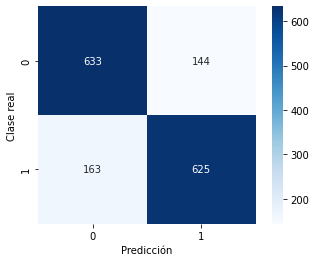

In [60]:
show_results(y_val, voting_classfication.predict(X_val))

Se han obtenido unos buenos resultados con un 80 % para los datos de validación, y con muy poco sobreajuste ya que para los datos de entrenamiento se ha obtenido casi un 85 %.

# 7. Predicción test

Para acabar con este cuaderno vamos predecir el conjunto de datos de test. Para ello leemos los datos del `.csv`.

In [61]:
filepath = 'test.csv'
test = pd.read_csv(filepath)
test.sample(5, random_state=seed)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
544,1135_02,Europa,False,NaN,55 Cancri e,61.0,False,26.0,3606.0,NaN,0.0,138.0,Toperon Coarswing
410,0858_02,Mars,True,F/178/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,NaN,Hion Mad
2554,5588_01,Mars,False,F/1066/S,TRAPPIST-1e,24.0,False,18.0,25.0,0.0,0.0,1256.0,Weres Cola
1281,2731_01,Earth,True,G/434/S,TRAPPIST-1e,24.0,NaN,0.0,0.0,0.0,0.0,0.0,Rone Fersongs
598,1227_01,Europa,True,E/88/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Anchib Spedlybood


Utilizamos el modelo final para predecir estos datos y construimos un dataframe con el formato requerido en la competición de kaggle.

In [62]:
pred = voting_classfication.predict(test)

In [63]:
transported = pd.Series(pred, name='Transported')
submission = pd.concat([test['PassengerId'], transported], axis=1)

In [64]:
submission.sample(5, random_state=seed)

,PassengerId,Transported
544,1135_02,True
410,0858_02,True
2554,5588_01,False
1281,2731_01,True
598,1227_01,True


In [65]:
submission.to_csv('submission.csv', index=False)

Finalmente, generamos un archivo `submission.csv` con las predicciones. Con estas predicciones se ha obtenido un `accuracy` de 80.383 % para el conjunto de test en la competición de kaggle, el cual es muy buen `accuracy`.

Podemos observar que es un valor muy similar que el obtenido para los datos de validación. Eso es debido a que hemos eliminado el sobreajuste en los modelos definidos.